In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [3]:
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2012-10-19,11.74,11.97,11.62,11.94,23177.45,272640.88
2012-10-20,11.74,11.85,11.56,11.74,22110.92,259113.16
2012-10-21,11.63,11.77,11.61,11.74,9375.52,109479.89
2012-10-22,11.71,11.81,11.47,11.63,37622.03,440140.37
2012-10-23,11.65,12.00,11.41,11.71,54344.49,637306.00


In [4]:
target_col = 'close'

In [5]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [6]:
train, test = train_test_split(hist, test_size=0.1)

## Plot data

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

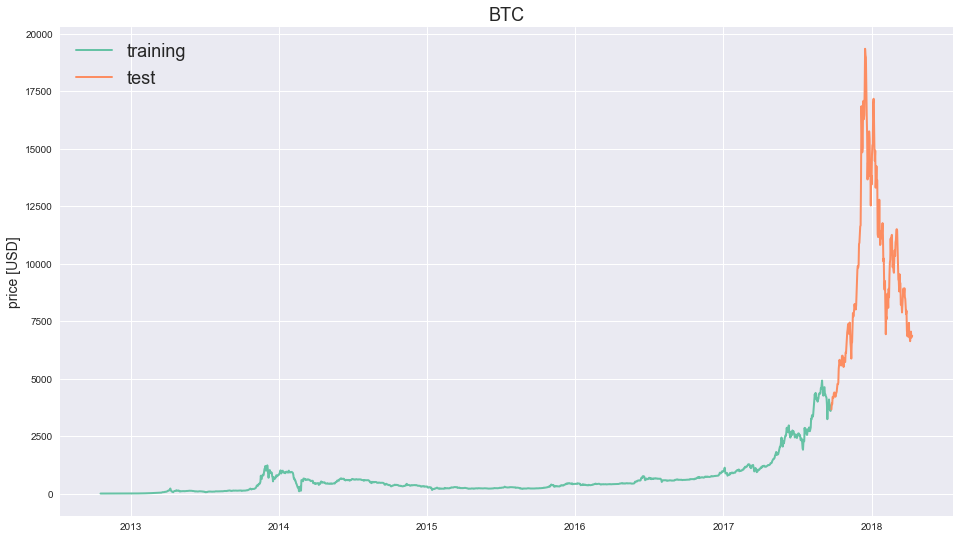

In [8]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

## LSTM

In [9]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [10]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [11]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [13]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [14]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [15]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1794/1794 [==============================] - 13s 7ms/step - loss: 0.0747
Epoch 2/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0530
Epoch 3/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0470
Epoch 4/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0438
Epoch 5/50
1794/1794 [==============================] - 12s 6ms/step - loss: 0.0414
Epoch 6/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0401: 0s - lo
Epoch 7/50
1794/1794 [==============================] - 11s 6ms/step - loss: 0.0401
Epoch 8/50
1794/1794 [==============================] - 11s 6ms/step - loss: 0.0393
Epoch 9/50
1794/1794 [==============================] - 12s 6ms/step - loss: 0.0387
Epoch 10/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0377
Epoch 11/50
1794/1794 [==============================] - 12s 7ms/step - loss: 0.0376
Epoch 12/50
1794/1794 [==============================] - 11s 6ms/

## Plot predictions

In [16]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [17]:
mean_absolute_error(preds, y_test)

0.044705889968596577

In [18]:
# 0.045261384613638447 with mae

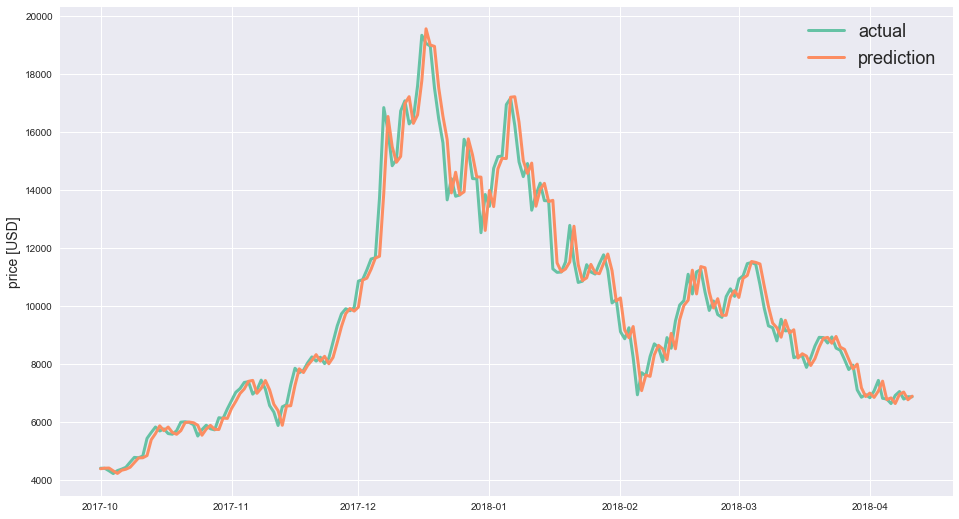

In [19]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

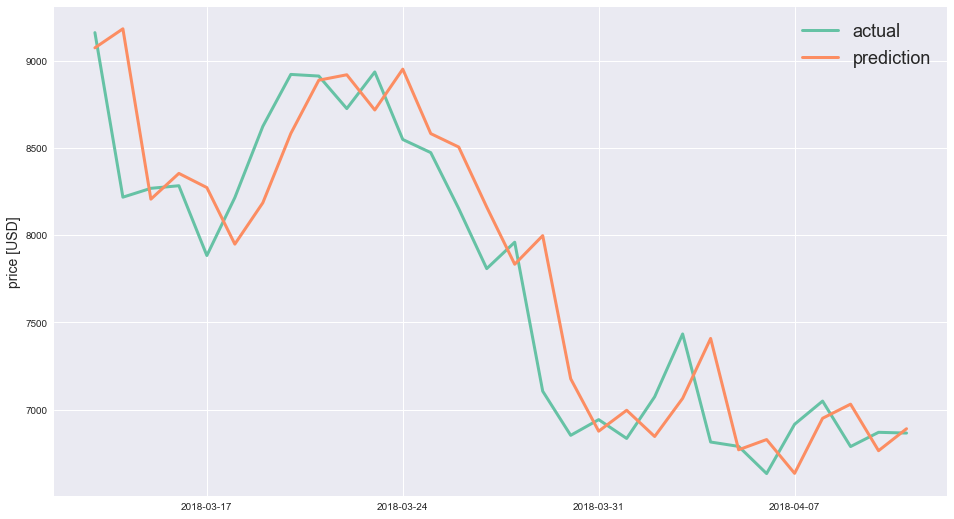

In [20]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

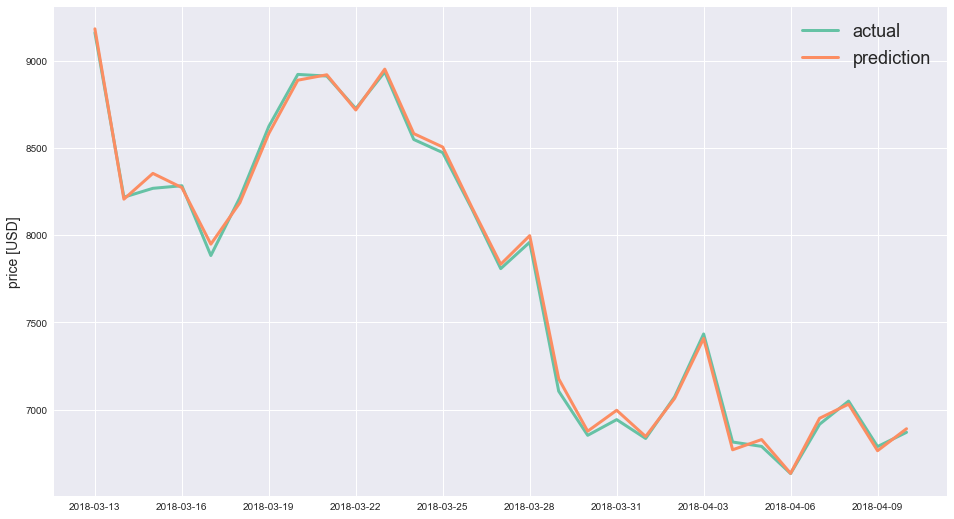

In [21]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

## Compare returns

In [22]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [23]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

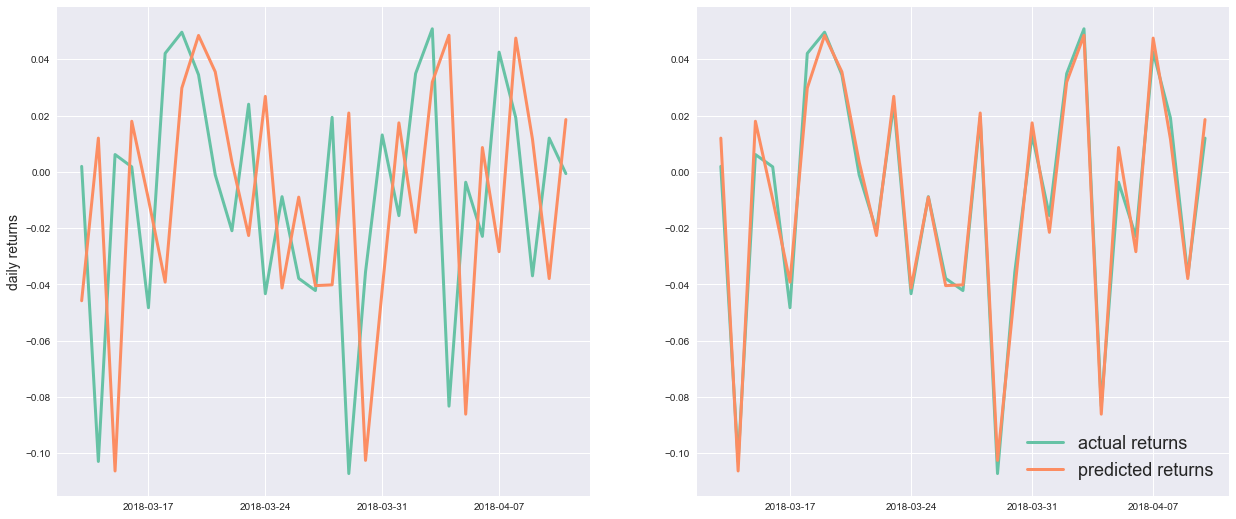

In [24]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

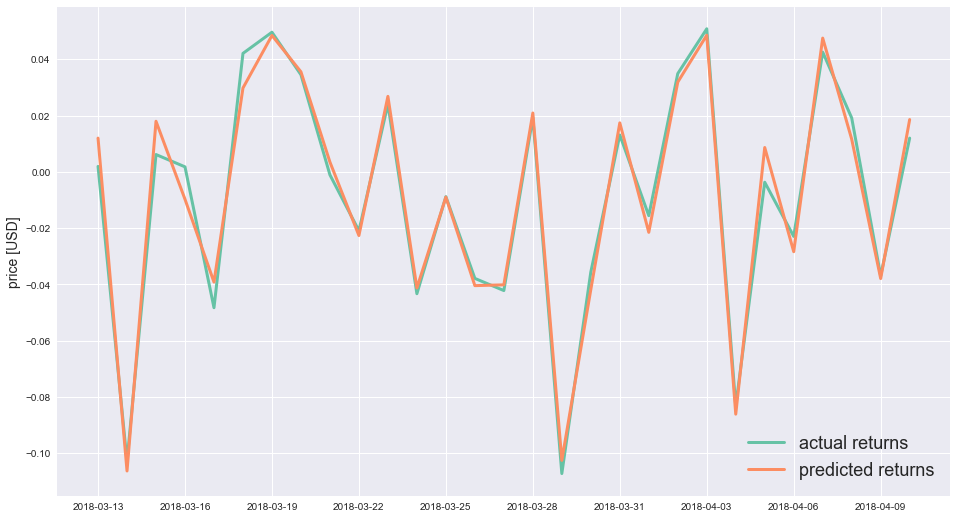

In [25]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

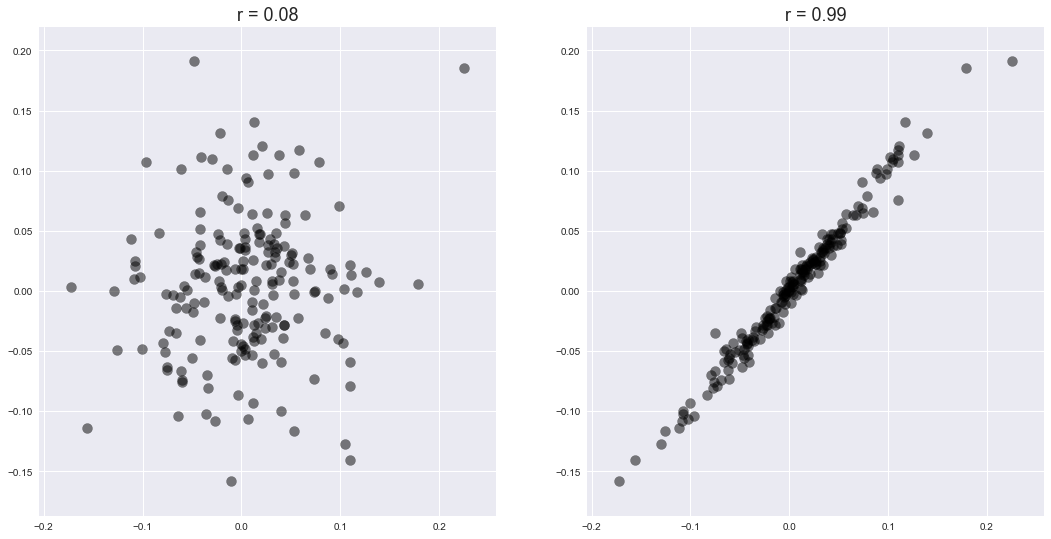

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);